In [23]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

### Get a sample stock price from 2019-01-01 to today

In [24]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2012-01-01','2020-04-30')
data.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-01-03  58.485714  58.928570  58.428570  58.747143  50.857235  75555200
2012-01-04  58.571430  59.240002  58.468571  59.062859  51.130558  65005500
2012-01-05  59.278572  59.792858  58.952858  59.718571  51.698215  67817400
2012-01-06  59.967144  60.392857  59.888573  60.342857  52.238651  79573200
2012-01-09  60.785713  61.107143  60.192856  60.247143  52.155792  98506100

### Extract the Close price column to plot

In [25]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

In [26]:
df

Date       Close
0    2012-01-03   58.747143
1    2012-01-04   59.062859
2    2012-01-05   59.718571
3    2012-01-06   60.342857
4    2012-01-09   60.247143
...         ...         ...
2089 2020-04-23  275.029999
2090 2020-04-24  282.970001
2091 2020-04-27  283.170013
2092 2020-04-28  278.579987
2093 2020-04-29  287.730011

[2094 rows x 2 columns]

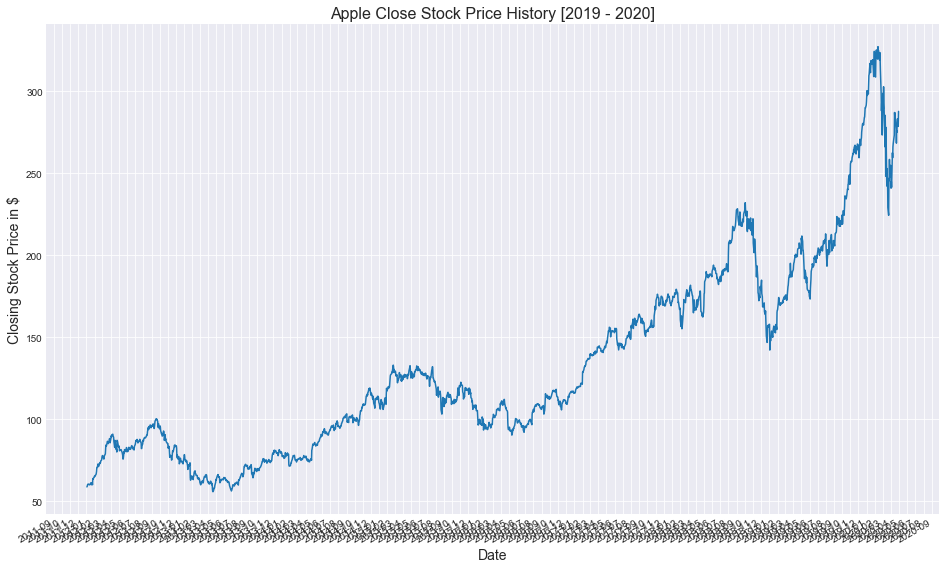

In [27]:
# Import matplotlib package for date plots

months = mdates.MonthLocator() # Get every year
dateFmt = mdates.DateFormatter('%Y-%m') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Get stock of Apple, Google, Microsoft, Amazon, Facebook via Yahoo Finance

In [30]:
def get_close_stock_price(codes, start_date='2012-01-01', end_date='2020-04-30'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('data/close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [31]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()
# df.head() actually takes the head of the dataframe. You can see that the output only has 5 rows

AAPL       GOOGL       MSFT        AMZN         FB
Date                                                               
2012-05-18  75.768570  300.500488  29.270000  213.850006  38.230000
2012-05-21  80.182854  307.362366  29.750000  218.110001  34.029999
2012-05-22  79.567146  300.700714  29.760000  215.330002  31.000000
2012-05-23  81.508568  305.035034  29.110001  217.279999  32.000000
2012-05-24  80.760002  302.132141  29.070000  215.240005  33.029999

In [32]:
df.index

DatetimeIndex(['2012-05-18', '2012-05-21', '2012-05-22', '2012-05-23',
               '2012-05-24', '2012-05-25', '2012-05-29', '2012-05-30',
               '2012-05-31', '2012-06-01',
               ...
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29'],
              dtype='datetime64[ns]', name='Date', length=1999, freq=None)

In [33]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

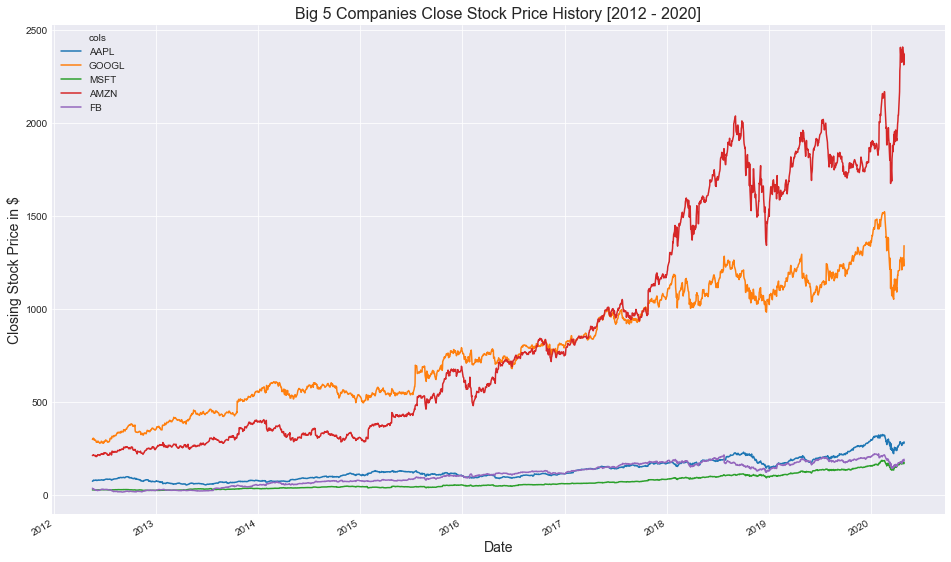

In [34]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2012 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Create X, y matrices for regression
Use history = number of days before prediction date

In [35]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X, y, dates = create_Xy(df, history=5)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

### Create a Linear Regression Model to predict stock price

In [36]:
# model
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

In [42]:
mean_squared_error(ypred, y_test)

377.498395142412

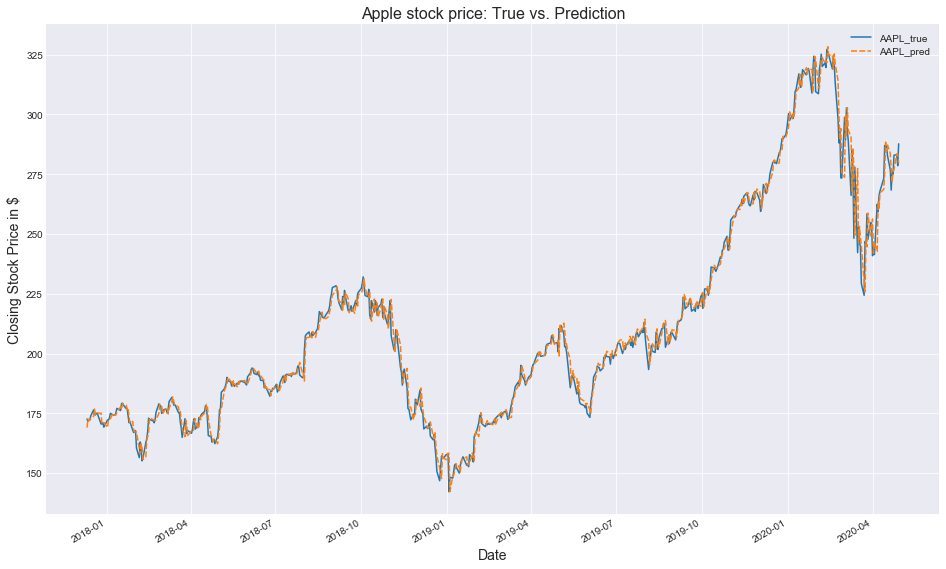

In [38]:
df_plot = pd.DataFrame({"AAPL_true": y_test[:,0], 'AAPL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Apple stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

# Exercise
1. Play with the above code to get familiar with stock price data and ways to create training data ( X = past stock price, y = future stock price )
2. Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )
3. Determine the features that could predict future stock price ( stock price from Yahoo Finance could be considered as raw features, create new features if needed )
4. Build a linear regression model to predict future stock price
5. Evaluate your model performance

Text(0, 0.5, 'GOOGL')

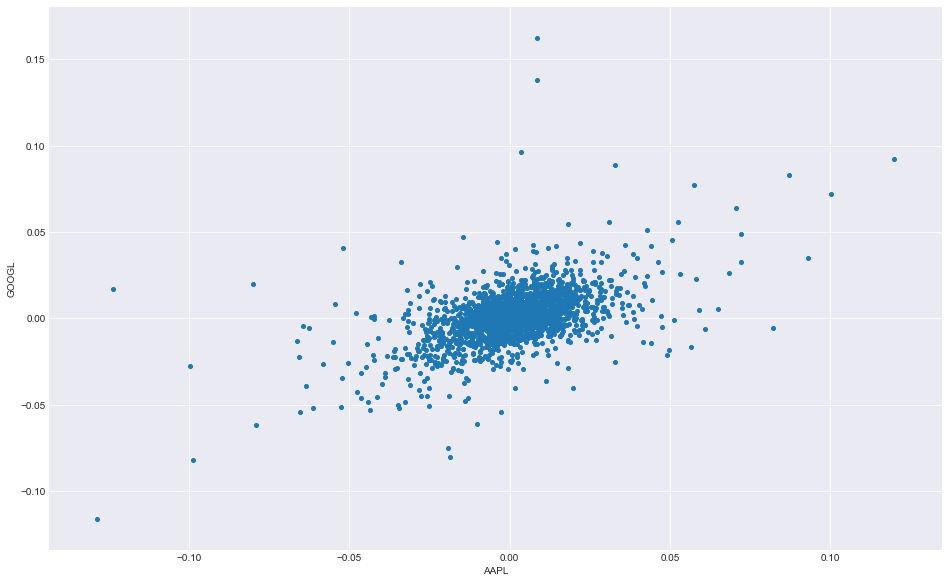

In [39]:
pct = df.pct_change()
plt.scatter(pct.AAPL, pct.GOOGL)
plt.xlabel('AAPL')
plt.ylabel('GOOGL')

In [40]:
pct.corr()

AAPL     GOOGL      MSFT      AMZN        FB
AAPL   1.000000  0.519106  0.551098  0.419733  0.366184
GOOGL  0.519106  1.000000  0.634554  0.597365  0.482885
MSFT   0.551098  0.634554  1.000000  0.534474  0.396318
AMZN   0.419733  0.597365  0.534474  1.000000  0.427496
FB     0.366184  0.482885  0.396318  0.427496  1.000000

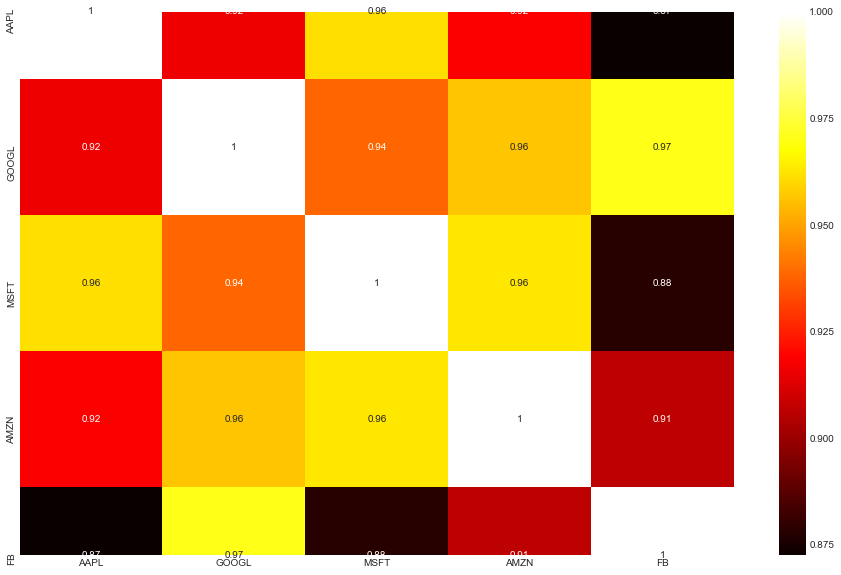

In [41]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='hot')